<a href="https://colab.research.google.com/github/sushvij/assignment7/blob/main/Copy_of_Sush_Copy_of_fuel_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# ⛽ Fuel efficiency Prediction

Provided with the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset, we will predict the **fuel efficiency** of the late-1970s and early 1980s automobiles, leveraging features such as cylinders, displacement, horsepower, weight, etc. 

It is a very small dataset and there are only a few features. We will first build a linear model and a neural network, evaluate their performances, track our experiment runs and inspect the logs using MLflow, and apply [TPOT](https://github.com/EpistasisLab/tpot) to see how it can be used to search over many ML model architectures, followed by explaining the model with SHAP.

# 📚 Learning Objectives

By the end of this session, you will be able to

- understand the core building blocks of a neural network
- understand what dense and activation layers do
- build, train, and evaluate neural networks
- track tensorflow experiments with MLflow, access information of runs programmatically and with its tracking ui
- perform AutoML to search for optimal tree-based pipeline for a regression task 

Note: [State of Data Science and Machine Learning 2021](https://www.kaggle.com/kaggle-survey-2021) by Kaggle shows that the most commonly used algorithms were linear and logtistic regressions, followed closely by decision trees, random forests, and gradient boosting machines (are you surprised?). Multilayer perceptron, or artificial neural networks are not yet the popular tools for tabular/structured data; see more technical reasons in papers: [Deep Neural Networks and Tabular Data: A Survey](https://arxiv.org/abs/2110.01889), [Tabular Data: Deep Learning is Not All You Need](https://arxiv.org/abs/2106.03253). For this assignment, the main purpose is for you to get familiar with the basic building blocks in constructing neural networks before we dive into more specialized neural network architectures.


**IMPORTANT**

You only need to run the following cells if you're completing the assignment in Google Collab. If you've already installed these libraries locally, you can skip installing these libraries.

In [1]:
# Connect colab to your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q seaborn # pairplot
!pip install -q tpot  # automl

!pip install -q mlflow # tracking
!pip install -q pyngrok # workaround to run mlflow ui in colab
!pip install -q shap

     |████████████████████████████████| 87 kB 4.0 MB/s 
     |████████████████████████████████| 255.9 MB 46 kB/s 
     |████████████████████████████████| 139 kB 63.3 MB/s 
     |████████████████████████████████| 17.0 MB 6.6 MB/s 
     |████████████████████████████████| 182 kB 57.7 MB/s 
     |████████████████████████████████| 79 kB 6.5 MB/s 
     |████████████████████████████████| 209 kB 61.8 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 147 kB 55.5 MB/s 
     |████████████████████████████████| 78 kB 7.8 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 140 kB 48.7 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 745 kB 6.7 MB/s 
     |████████████████████████████████| 569 kB 8.0 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


# Task 1 - Data: Auto MPG dataset

0. Start MLflow's automatic logging using library-specific autolog calls for tensorflow: logging metrics, parameters, and models without the need for explicit log statements. 
    
    We will get into more details using **MLflow** after completing our experiment.

In [5]:
import mlflow
mlflow.tensorflow.autolog() # MLflow Autologging

1. The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/). First download and import the dataset using `pandas`:


In [6]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = [
  'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
  'Acceleration', 'Model Year', 'Origin'
  ]

dataset = pd.read_csv(url, names=column_names, na_values='?', 
                      comment='\t', sep=' ', skipinitialspace=True)

In [7]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [8]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

2. The dataset contains a few unknown values, we drop those rows to keep this initial tutorial simple. Use `pd.DataFrame.dropna()`:

In [9]:
dataset = dataset.dropna() # YOUR CODE HERE

In [10]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

3. The `"Origin"` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

In [11]:
dataset['Origin'] = dataset['Origin'].replace({1: 'USA', 2: 'Europe', 3: 'Japan'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


4. Split the data into training and test sets. To reduce the module importing overhead, instead of `sklearn.model_selection.train_test_split()`, use `pd.DataFrame.sample()` to save 80% of the data aside to `train_dataset`, set the random state to be 0 for reproducibility. 

   Then use `pd.DataFrame.drop()` to obtain the `test_dataset`.

In [13]:
train_dataset = dataset.sample(frac = .8) # YOUR CODE HERE
rows_to_drop = train_dataset.index.values
test_dataset = dataset.drop(labels = rows_to_drop, axis=0) # YOUR CODE HERE

In [14]:
train_dataset.shape

(314, 10)

In [15]:
test_dataset.shape

(78, 10)

In [16]:
dataset.shape

(392, 10)

5. Review the pairwise relationships of a few pairs of columns from the training set. 
   
   The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

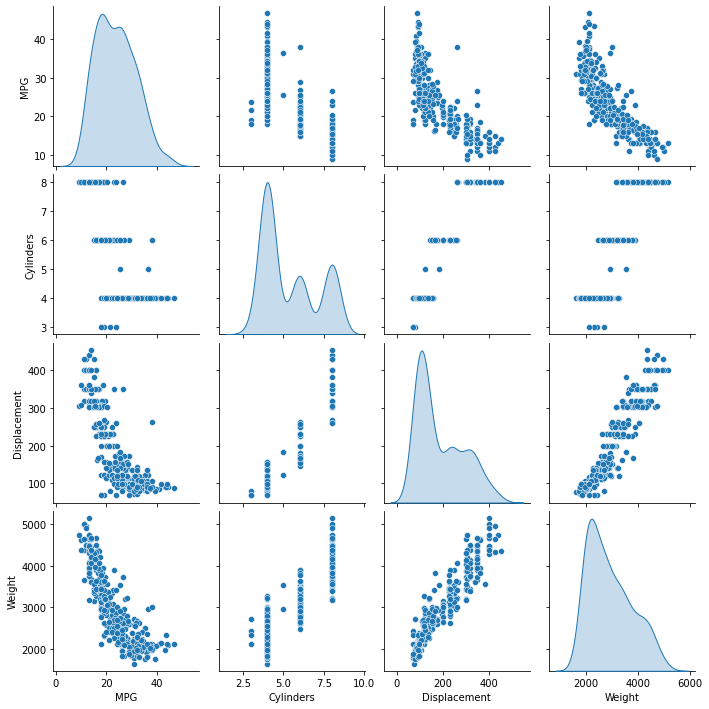

In [17]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde');

Let's also check the overall statistics. Note how each feature covers a very different range:

In [18]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.688217,7.722190,9.0,17.775,23.0,29.0,46.6
Cylinders,314.0,5.382166,1.690171,3.0,4.000,4.0,6.0,8.0
Displacement,314.0,187.714968,101.100553,68.0,98.000,140.0,258.0,454.0
Horsepower,314.0,101.872611,36.864006,46.0,75.000,90.5,115.0,230.0
Weight,314.0,2928.044586,836.809515,1649.0,2204.000,2722.5,3463.5,5140.0
Acceleration,314.0,15.692994,2.745920,8.0,14.000,15.5,17.3,24.8
Model Year,314.0,76.000000,3.645646,70.0,73.000,76.0,79.0,82.0
Europe,314.0,0.184713,0.388684,0.0,0.000,0.0,0.0,1.0
Japan,314.0,0.207006,0.405807,0.0,0.000,0.0,0.0,1.0
USA,314.0,0.608280,0.488914,0.0,0.000,1.0,1.0,1.0


6. Split features from labels. 
  This means, separate the target value(also called"label") from the features. 
  Label is the value that you will train the model to predict.

In [19]:
train_features = train_dataset.drop(['MPG'], axis=1) # YOUR CODE HERE
test_features = test_dataset.drop(['MPG'], axis=1) # YOUR CODE HERE

train_labels = train_dataset['MPG'] # YOUR CODE HERE
test_labels = test_dataset['MPG'] # YOUR CODE HERE

In [20]:
train_features.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
315,4,151.0,90.0,3003.0,20.1,80,0,0,1
286,8,302.0,129.0,3725.0,13.4,79,0,0,1
86,8,304.0,150.0,3672.0,11.5,73,0,0,1
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
366,6,225.0,85.0,3465.0,16.6,81,0,0,1


# Task 2 - Normalization Layer

It is good practice to normalize features that use different scales and ranges. Although a model *might* converge without feature normalization, normalization makes training much more stable.

Similar to scikit-learn, tensorflow.keras offers a list of [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) so that you can build and export models that are truly end-to-end.

1. The Normalization layer ([`tf.keras.layers.Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) is a clean and simple way to add feature normalization into your model. The first step is to create the layer:

In [21]:
normalizer = tf.keras.layers.Normalization(axis=-1) # YOUR CODE HERE

2. Then, fit the state of the preprocessing layer to the data by calling [`Normalization.adapt`](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method):

In [22]:
normalizer.adapt(np.array(train_features))# YOUR CODE HERE

We can see the feature mean and variance are stored in the layer:

In [23]:
print(f'feature mean: {normalizer.mean.numpy().squeeze()}\n')
print(f'feature variance: {normalizer.variance.numpy().squeeze()}')

feature mean: [   5.382  187.715  101.873 2928.045   15.693   76.       0.185    0.207
    0.608]

feature variance: [     2.848  10188.77    1354.627 698020.1        7.516     13.248
      0.151      0.164      0.238]


When the layer is called, it returns the input data, with each feature independently normalized:

In [24]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.   151.    90.  3003.    20.1   80.     0.     0.     1. ]]

Normalized: [[-0.82 -0.36 -0.32  0.09  1.61  1.1  -0.48 -0.51  0.8 ]]


# Task 3 - Linear Regression 📈

Before building a deep neural network model, start with linear regression using all the features.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in this multivariate linear regression model:

- Normalize all the input features using the `tf.keras.layers.Normalization` preprocessing layer. You have defined this earlier as `normalizer`.
- Apply a linear transformation ($y = mx+b$ where $m$ is a matrix and $b$ is a vector.) to produce one output using a linear layer ([`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

In [25]:
normalized_data = normalizer(train_features) #step 1

In [26]:
normalized_data.shape

TensorShape([314, 9])

1. Build the Keras Sequential model:

In [27]:
linear_model = tf.keras.Sequential([
        normalizer,
        layers.Dense(units=1)
    # YOUR CODE HERE
    # YOUR CODE HERE
])

In [28]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


2. This model will predict `'MPG'` from all features in `train_features`. Run the untrained model on the first 10 data points / rows using `Model.predict()`. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [29]:
linear_model.predict(train_features[:10]) # YOUR CODE HERE

1/1 [==============================] - 0s 210ms/step


array([[-0.324],
       [-2.855],
       [-1.908],
       [-1.139],
       [-1.701],
       [-1.044],
       [ 1.213],
       [ 0.185],
       [-2.881],
       [-2.911]], dtype=float32)

3. When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y = mx + b$) have a shape of (9, 1):

In [30]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.699],
       [-0.37 ],
       [-0.276],
       [-0.1  ],
       [ 0.054],
       [-0.694],
       [ 0.166],
       [-0.264],
       [-0.613]], dtype=float32)>

4. Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized and how (using the `tf.keras.optimizers.Adam`).

  Here's a list of built-in loss functions in [`tf.keras.losses`](https://www.tensorflow.org/api_docs/python/tf/keras/losses). For regression tasks, [common loss functions](https://towardsdatascience.com/understanding-the-3-most-common-loss-functions-for-machine-learning-regression-23e0ef3e14d3) include mean squared error (MSE) and mean absolute error (MAE). Here,  MAE is preferred such that the model is more robust against outliers. 

  For optimizers, gradient descent (check this video [Gradient Descent, Step-by-Step](https://www.youtube.com/watch?v=sDv4f4s2SB8) for a refresher) is the preferred way to optimize neural networks and many other machine learning algorithms. Read [an overview of graident descent optimizer algorithms](https://ruder.io/optimizing-gradient-descent/) for several popular gradient descent algorithms. Here, we use the popular [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), and set the learning rate at 0.1 for faster learning.  

In [31]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), # YOUR CODE HERE
    loss= 'mean_absolute_error' # YOUR CODE HERE
    )

5. Use Keras `Model.fit` to execute the training for 100 epochs, set the verbose to 0 to suppress logging and keep 20% of the data for validation:

In [32]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

2022/11/23 01:38:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5ac16c6dac0d4978882a866ffcda1ddf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2022/11/23 01:38:29 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp8k1vmz52/model, flavor: keras), fall back to return ['tensorflow==2.9.2', 'keras==2.9.0']. Set logging level to DEBUG to see the full traceback.


CPU times: user 8.11 s, sys: 448 ms, total: 8.55 s
Wall time: 19 s


6. Visualize the model's training progress using the stats stored in the `history` object:

In [33]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,2.568394,2.424645,95
96,2.592695,2.439606,96
97,2.570510,2.298625,97
98,2.572975,2.384646,98
99,2.564853,2.434479,99


In [34]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

Use `plot_loss(history)` provided to visualize the progression in loss function for training and validation data sets. 

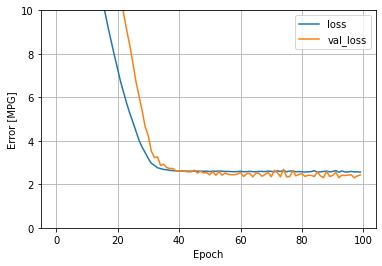

In [35]:
plot_loss(history) # YOUR CODE HERE

7. Collect the results on the test set for later using [`Model.evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate)

In [36]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0) # YOUR CODE HERE

In [37]:
test_results

{'linear_model': 2.180881977081299}

# Task 4 - Regression with a Deep Neural Network (DNN)

You just implemented a linear model for multiple inputs. Now, you are ready to implement multiple-input DNN models.

The code is very similar except the model is expanded to include some "hidden" **non-linear** layers. The name "hidden" here just means not directly connected to the inputs or outputs.

* The normalization layer, as before (with `normalizer` for a multiple-input model).
* Two hidden, non-linear, [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers with the ReLU (`relu`) activation function nonlinearity. One way is to set parameter `activation` inside `Dense` Set the number of neurons at each layer to be 64. 
* A linear `Dense` single-output layer. 



1. Include the model and `compile` method in the `build_and_compile_model` function below. 

In [38]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])
  
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())
  return model

2. Create a DNN model with `normalizer` (defined earlier) as the normalization layer:



In [39]:
dnn_model = build_and_compile_model(normalizer) # YOUR CODE HERE

3. Inspect the model using `Model.summary()`. This model has quite a few more trainable parameters than the linear models:

In [40]:
dnn_model.summary()# YOUR CODE HERE

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                640       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


4. Train the model with Keras `Model.fit`:

In [41]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

2022/11/23 01:38:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1319f46c50254965b6f22e937ac4e23f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2022/11/23 01:38:42 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.25+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.25' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


CPU times: user 7.03 s, sys: 286 ms, total: 7.32 s
Wall time: 12.5 s


5. Visualize the model's training progress using the stats stored in the history object. 

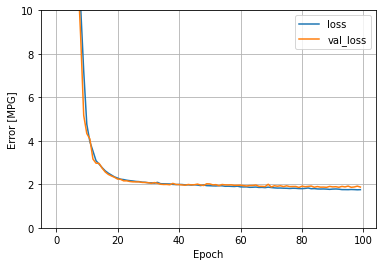

In [42]:
plot_loss(history)

Do you think the DNN model is overfitting? What gives away? 

It's likely. Clearly the model above continues to learn past epoch 20. The loss of the training sample is getting lower and lower over epochs 20 - 100. On the other hand, it looks like the loss in the validation sample (orange line), stabilizes after the 20th epoch. Hence it is increasingly not performing as well as the training sample loss (blue line) as the model continues to learn. In contrast we see in the linear model, while obviously the validation sample has a worse loss, the difference in performace to the training sample is static. 

6. Let's save the results for later comparison.

In [43]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

# Task 5 - Make Predictions 🔮

1. Since both models have been trained, we can review their test set performance:

In [44]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.180882
dnn_model,1.721870


These results match the validation error observed during training.

2. We can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss. Use `.flatten()`.

3/3 [==============================] - 0s 7ms/step


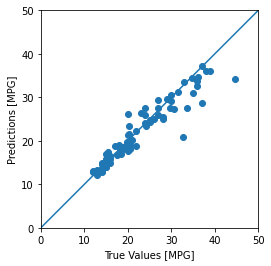

In [45]:
test_predictions = dnn_model.predict(test_features).flatten() # YOUR CODE HERE

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


3. It appears that the model predicts reasonably well. Now, check the error distribution:

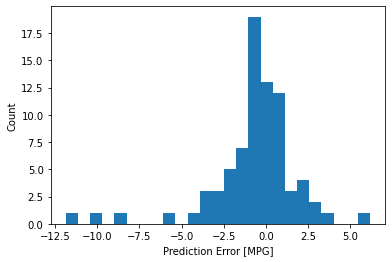

In [46]:
error = test_predictions - test_labels # YOUR CODE HERE
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

4. Save it for later use with `Model.save`:

In [47]:
dnn_model.save('dnn_model')

5. Reload the model with `Model.load_model`; it gives identical output:

In [48]:
reloaded = tf.keras.models.load_model(
    'dnn_model', custom_objects=None, compile=True, options=None
) # YOUR CODE HERE

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [49]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.180882
dnn_model,1.721870
reloaded,1.721870


# Task 6 - Nonlinearity

We mentioned that the `relu` activation function introduce non-linearity; let's visualize it. Since there are six numerical features and 1 categorical features, it is impossible to plot all the dimensions on a 2D plot; we need to simplify/isolate it. 

Note: in this task, code is provided; the focus in on understanding. 

1. We focus on the relationship between feature `Displacement` and target `MPG`. 
  
  To do so, create a new dataset of the same size as `train_features`, but all other features are set at their median values; then set the `Displacement` between 0 and 500. 

In [50]:
fake = np.outer(np.ones(train_features.shape[0]), train_features.median())
fake = pd.DataFrame(fake, columns = train_features.columns)
fake.Displacement = np.linspace(0, 500, train_features.shape[0])

2. Create a plotting function to:

    a) visualize real values between `Displacement` and `MPG` from the training dataset in scatter plot 
    
    b) overlay the predicted MPG from Displacement varying from 0 to 500, but holding all other features constant. 

In [51]:
def plot_displacement(x, y):
    plt.scatter(train_features['Displacement'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Displacement')
    plt.ylabel('MPG')
    plt.legend()

3. Visualize predicted MPG using the linear model.

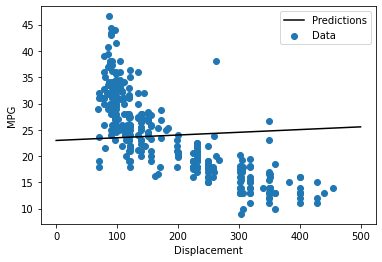

In [52]:
plot_displacement(fake.Displacement, linear_model(fake))

4. Visualize predicted MPG using the neural network model. Do you see an improvement/non-linearity from the linear model? 

10/10 [==============================] - 0s 2ms/step


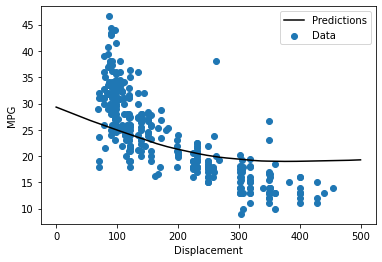

In [53]:
plot_displacement(fake.Displacement, dnn_model.predict(fake))

5. What are the other activation functions? Check the list of [activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations). 
  
  Optional. Modify the DNN model with a different activation function, and fit it on the data; does it perform better? 

## Activation functions are used in neural networks. 

The activation function is the non-linear function that we apply over the output data coming out of a particular layer of neurons before it propagates as the input to the next layer. If there is no activation function the layer is only performing a linear transformation of the inputs using weights and biases, i.e. essentially a linear regression.

It can be shown, mathematically, that the universal approximation power of a deep neural network - the ability to approximate any mathematical function to a sufficient degree - does not hold without these nonlinear activation stages in between the layers. Without it, the network will not be able to learn complex patterns from the data.

There are many types of activation functions as seen in the list below. Which one we choose, depends on the nature of the data. 

## In general:

1.   Sigmoid functions and their combinations generally work better in the case of classifiers
2.   Sigmoids and tanh functions are sometimes avoided due to the vanishing gradient problem (When there are more layers in the network, the value of the product of derivative decreases until at some point the partial derivative of the loss function approaches a value close to zero, and the partial derivative vanishes. )
3. ReLU function is a general activation function, is like a simple linear funtion, and is used in most cases these days. However, it is non-linear because it passes the input if it is above zero, like a linear function, but 0 if the input is negative.
4. If we encounter a case of dead neurons (only 0 weights are propogating forward) in our networks the leaky ReLU function is the best choice (small negative value if input is negative instead of zero)
5. ReLU function should only be used in the hidden layers

We would begin with ReLU function and then move over to other activation functions in case ReLU doesn’t provide optimum results.

deserialize(...): Returns activation function given a string identifier.

elu(...): Exponential Linear Unit.

exponential(...): Exponential activation function.

gelu(...): Applies the Gaussian error linear unit (GELU) activation function.

get(...): Returns function.

hard_sigmoid(...): Hard sigmoid activation function.

linear(...): Linear activation function (pass-through).

relu(...): Applies the rectified linear unit activation function.

selu(...): Scaled Exponential Linear Unit (SELU).

serialize(...): Returns the string identifier of an activation function.

sigmoid(...): Sigmoid activation function, sigmoid(x) = 1 / (1 + exp(-x)).

softmax(...): Softmax converts a vector of values to a probability distribution.

softplus(...): Softplus activation function, softplus(x) = log(exp(x) + 1).

softsign(...): Softsign activation function, softsign(x) = x / (abs(x) + 1).

swish(...): Swish activation function, swish(x) = x * sigmoid(x).

tanh(...): Hyperbolic tangent activation function.

6. Overfitting is a common problem for DNN models, how should we deal with it? Check [Regularizers](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers) on tf.keras. Any other techiniques that are invented for neural networks?

1) get more data
2) augment the data - e.g. rotate images to have more training examples
3) reduce the model's complexility = remove layers, prune parameters
4) Weight regularization adds a function of the weights to the loss function. So when the network works to minimize loss, it encounters a penality for increasing the weights. When the network overfits on training data, the error between predicted & the actual value for training data is very small. Without a penality the network continues to reduce the gradient of the error and the weights remain close to the previous value. If a regularlization term is included, it penalizes the network’s large weights & forces the optimization algorithm to reduce the larger weight values to smaller weights. So mathematically speaking bigger changes are made if it is overfitting.

There are two types of regularization funcitons. L1 penalizes sum of the absolute weights and L2 regularization the sum of square of the weights. L1 will generate a model that is simpler and is robust to outliers. L2 can learn more complex patterns in the data but is not robust to outliers.

# Task 7 - MLflow Tracking

In this task, we briefly explore [MLflow Tracking](https://www.mlflow.org/docs/latest/tracking.html#tracking), one of four primary functions that MLflow offers for managing the end-to-end machine learning lifecycle. We will access the information runs programmatically in python and then set up the MLflow UI for easy interaction.

1. Experiments.

    MLflow Tracking is organized around the concept of `runs`, which are executions of some piece of modeling code; and runs are organized into experiments. 

    We set the auto logging in the beginning, we can verify that
    - there is one experiment
    - its name is `0`
    - all of its artifacts are stored at `file:///content/mlruns/0` in Google Drive.

In [54]:
from mlflow import MlflowClient
client = MlflowClient()
client.list_experiments() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


[<Experiment: artifact_location='file:///content/mlruns/0', creation_time=1669167490561, experiment_id='0', last_update_time=1669167490561, lifecycle_stage='active', name='Default', tags={}>]

2. Runs. 

   List information for runs that are under experiment '0' using [`mlflow.list_run_infos()`](https://www.mlflow.org/docs/latest/python_api/mlflow.html#mlflow.list_run_infos).

In [55]:
mlflow.list_run_infos('0')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: ``mlflow.tracking.fluent.list_run_infos`` is deprecated. This method will be removed in a future release. Use ``search_runs()`` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/mlflow/tracking/fluent.py:1612: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_run_infos`` is deprecated. This method will be removed in a future release. Use ``search_runs()`` instead.
  experiment_id, run_view_type, number_to_get, order_by, next_page_token


[<RunInfo: artifact_uri='file:///content/mlruns/0/1319f46c50254965b6f22e937ac4e23f/artifacts', end_time=1669167522625, experiment_id='0', lifecycle_stage='active', run_id='1319f46c50254965b6f22e937ac4e23f', run_name='dashing-mink-10', run_uuid='1319f46c50254965b6f22e937ac4e23f', start_time=1669167510176, status='FINISHED', user_id='root'>,
 <RunInfo: artifact_uri='file:///content/mlruns/0/5ac16c6dac0d4978882a866ffcda1ddf/artifacts', end_time=1669167509582, experiment_id='0', lifecycle_stage='active', run_id='5ac16c6dac0d4978882a866ffcda1ddf', run_name='gregarious-flea-848', run_uuid='5ac16c6dac0d4978882a866ffcda1ddf', start_time=1669167490838, status='FINISHED', user_id='root'>]

In [56]:
#curious about the search command because got a warning on list_run_infos
#sweeter looking output plus the wand allows filtering etc.
#so much better than previous command

mlflow.search_runs('0')

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.val_loss,metrics.loss,params.opt_beta_1,params.epochs,...,params.shuffle,params.initial_epoch,params.sample_weight,params.opt_name,tags.mlflow.autologging,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.source.name
0,1319f46c50254965b6f22e937ac4e23f,0,FINISHED,file:///content/mlruns/0/1319f46c50254965b6f22...,2022-11-23 01:38:30.176000+00:00,2022-11-23 01:38:42.625000+00:00,1.874804,1.753960,0.9,100,...,True,0,None,Adam,tensorflow,root,LOCAL,dashing-mink-10,"[{""run_id"": ""1319f46c50254965b6f22e937ac4e23f""...",/usr/local/lib/python3.7/dist-packages/ipykern...
1,5ac16c6dac0d4978882a866ffcda1ddf,0,FINISHED,file:///content/mlruns/0/5ac16c6dac0d4978882a8...,2022-11-23 01:38:10.838000+00:00,2022-11-23 01:38:29.582000+00:00,2.434479,2.564853,0.9,100,...,True,0,None,Adam,tensorflow,root,LOCAL,gregarious-flea-848,"[{""run_id"": ""5ac16c6dac0d4978882a866ffcda1ddf""...",/usr/local/lib/python3.7/dist-packages/ipykern...


3. Retrieve the currently active run, i.e., the DNN model. Hint: `mlflow.last_active_run()` 

In [57]:
autolog_run = mlflow.last_active_run() 
print(autolog_run) # YOUR CODE HERE

<Run: data=<RunData: metrics={'loss': 1.7539604902267456, 'val_loss': 1.8748040199279785}, params={'batch_size': 'None',
 'class_weight': 'None',
 'epochs': '100',
 'initial_epoch': '0',
 'max_queue_size': '10',
 'opt_amsgrad': 'False',
 'opt_beta_1': '0.9',
 'opt_beta_2': '0.999',
 'opt_decay': '0.0',
 'opt_epsilon': '1e-07',
 'opt_learning_rate': '0.001',
 'opt_name': 'Adam',
 'sample_weight': 'None',
 'shuffle': 'True',
 'steps_per_epoch': 'None',
 'use_multiprocessing': 'False',
 'validation_batch_size': 'None',
 'validation_freq': '1',
 'validation_split': '0.2',
 'validation_steps': 'None',
 'workers': '1'}, tags={'mlflow.autologging': 'tensorflow',
 'mlflow.log-model.history': '[{"run_id": "1319f46c50254965b6f22e937ac4e23f", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2022-11-23 01:38:36.513129", "flavors": '
                             '{"keras": {"keras_module": "tensorflow.keras", '
                          

4. Use function `print_auto_logged_info` provided below to fetch the auto logged parameters and metrics for `autolog_run`. 

In [58]:
import json
def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(json.dumps(r.data.params, indent=4)))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))

In [59]:
print_auto_logged_info(autolog_run)

run_id: 1319f46c50254965b6f22e937ac4e23f
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {
    "opt_epsilon": "1e-07",
    "sample_weight": "None",
    "opt_decay": "0.0",
    "steps_per_epoch": "None",
    "opt_amsgrad": "False",
    "use_multiprocessing": "False",
    "opt_beta_2": "0.999",
    "opt_beta_1": "0.9",
    "epochs": "100",
    "batch_size": "None",
    "validation_batch_size": "None",
    "validation_steps": "None",
    "shuffle": "True",
    "class_weight": "None",
    "validation_freq": "1",
    "initial_epoch": "0",
    "max_queue_size": "10",
    "workers": "1",
    "validation_split": "0.2",
    "opt_name": "Adam",
    "opt_learning_rate": "0.001"
}
metrics: {'val_loss': 1.8748040199279785, 'loss': 1.7539604902267456}
tags: {}


5. Optional. Retrieve the best run using [MlflowClient().search_runs()](https://www.mlflow.org/docs/latest/search-runs.html#python).

In [60]:
from mlflow.entities import ViewType

run = MlflowClient().search_runs(
  experiment_ids="0",
  filter_string="",
  run_view_type=ViewType.ACTIVE_ONLY,
  max_results=1,
  order_by=["metrics.accuracy DESC"]
)[0]

# runs = None # YOUR CODE HERE

In [61]:
run

<Run: data=<RunData: metrics={'loss': 1.7539604902267456, 'val_loss': 1.8748040199279785}, params={'batch_size': 'None',
 'class_weight': 'None',
 'epochs': '100',
 'initial_epoch': '0',
 'max_queue_size': '10',
 'opt_amsgrad': 'False',
 'opt_beta_1': '0.9',
 'opt_beta_2': '0.999',
 'opt_decay': '0.0',
 'opt_epsilon': '1e-07',
 'opt_learning_rate': '0.001',
 'opt_name': 'Adam',
 'sample_weight': 'None',
 'shuffle': 'True',
 'steps_per_epoch': 'None',
 'use_multiprocessing': 'False',
 'validation_batch_size': 'None',
 'validation_freq': '1',
 'validation_split': '0.2',
 'validation_steps': 'None',
 'workers': '1'}, tags={'mlflow.autologging': 'tensorflow',
 'mlflow.log-model.history': '[{"run_id": "1319f46c50254965b6f22e937ac4e23f", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2022-11-23 01:38:36.513129", "flavors": '
                             '{"keras": {"keras_module": "tensorflow.keras", '
                          

6. To see what's logged in the file system `/content/mlruns/`, click tab `files` in the left sidepanel in Colab. For example, 
    ```
    mlruns
    └── 0
        ├── 3a5aebdd35ef46fb8dc35b40e542f0a4
        │   ├── artifacts
        │   ├── meta.yaml
        │   ├── metrics
        │   ├── params
        │   └── tags
        ├── c627bc526c4a4c418a8285627e61a16d
        │   ├── artifacts
        │   ├── meta.yaml
        │   ├── metrics
        │   ├── params
        │   └── tags
        └── meta.yaml

    11 directories, 3 files
    ```

    Inspect the model summary of the DNN model you ran previously; it is located at `artifacts/model_summary.txt` of the corresponding run. Use `cat $filepath`. 

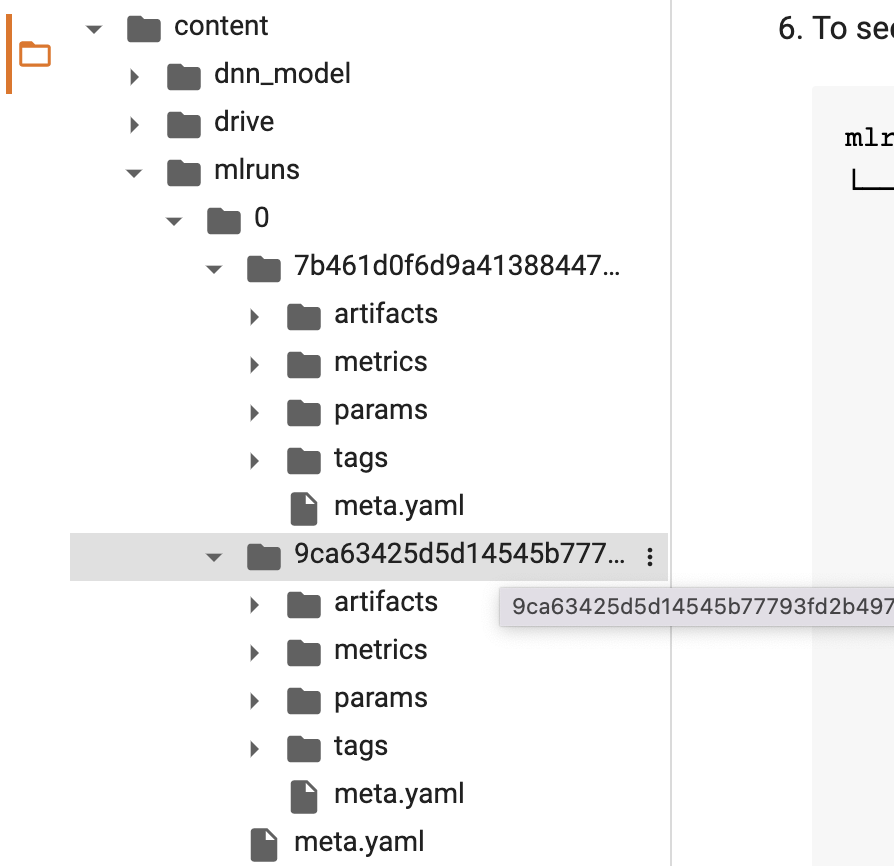

In [62]:
cat /content/mlruns/0/9ca63425d5d14545b77793fd2b4971c6/artifacts/model_summary.txt # YOUR CODE HERE (bash)

cat: /content/mlruns/0/9ca63425d5d14545b77793fd2b4971c6/artifacts/model_summary.txt: No such file or directory


7. Tracking UI. 

    MLflow provides an UI for us to visualize, search and compare runs, as well as download run artifacts or metadata for analysis in other tools. 

    If your runs are logged to a local mlruns directory, run `mlflow ui` in the directory above it will load the corresponding runs. 
    
    Running localhost server in Colab, however, requires a bit of extra work:
    - set up a free account on [ngrok](https://dashboard.ngrok.com/get-started/setup)
    - retrieve the authtoken from https://dashboard.ngrok.com/auth and update the code cell below
    
   **NOTE**. NEVER share your secrets. Best to keep `NGROK_AUTH_TOKEN` as an environment variable and retrieve it via `os.environ.get("NGROK_AUTH_TOKEN")`.

In [63]:
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") 

# create remote tunnel using ngrok.com to allow local port access
from pyngrok import ngrok
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (see Note above)
NGROK_AUTH_TOKEN = "2EpLAwBPBxY5nlcuUvddGKOumUD_7pfLCJRhe9ku896xysV46"  # YOUR CODE HERE
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://5041-35-233-241-193.ngrok.io


## so cool!

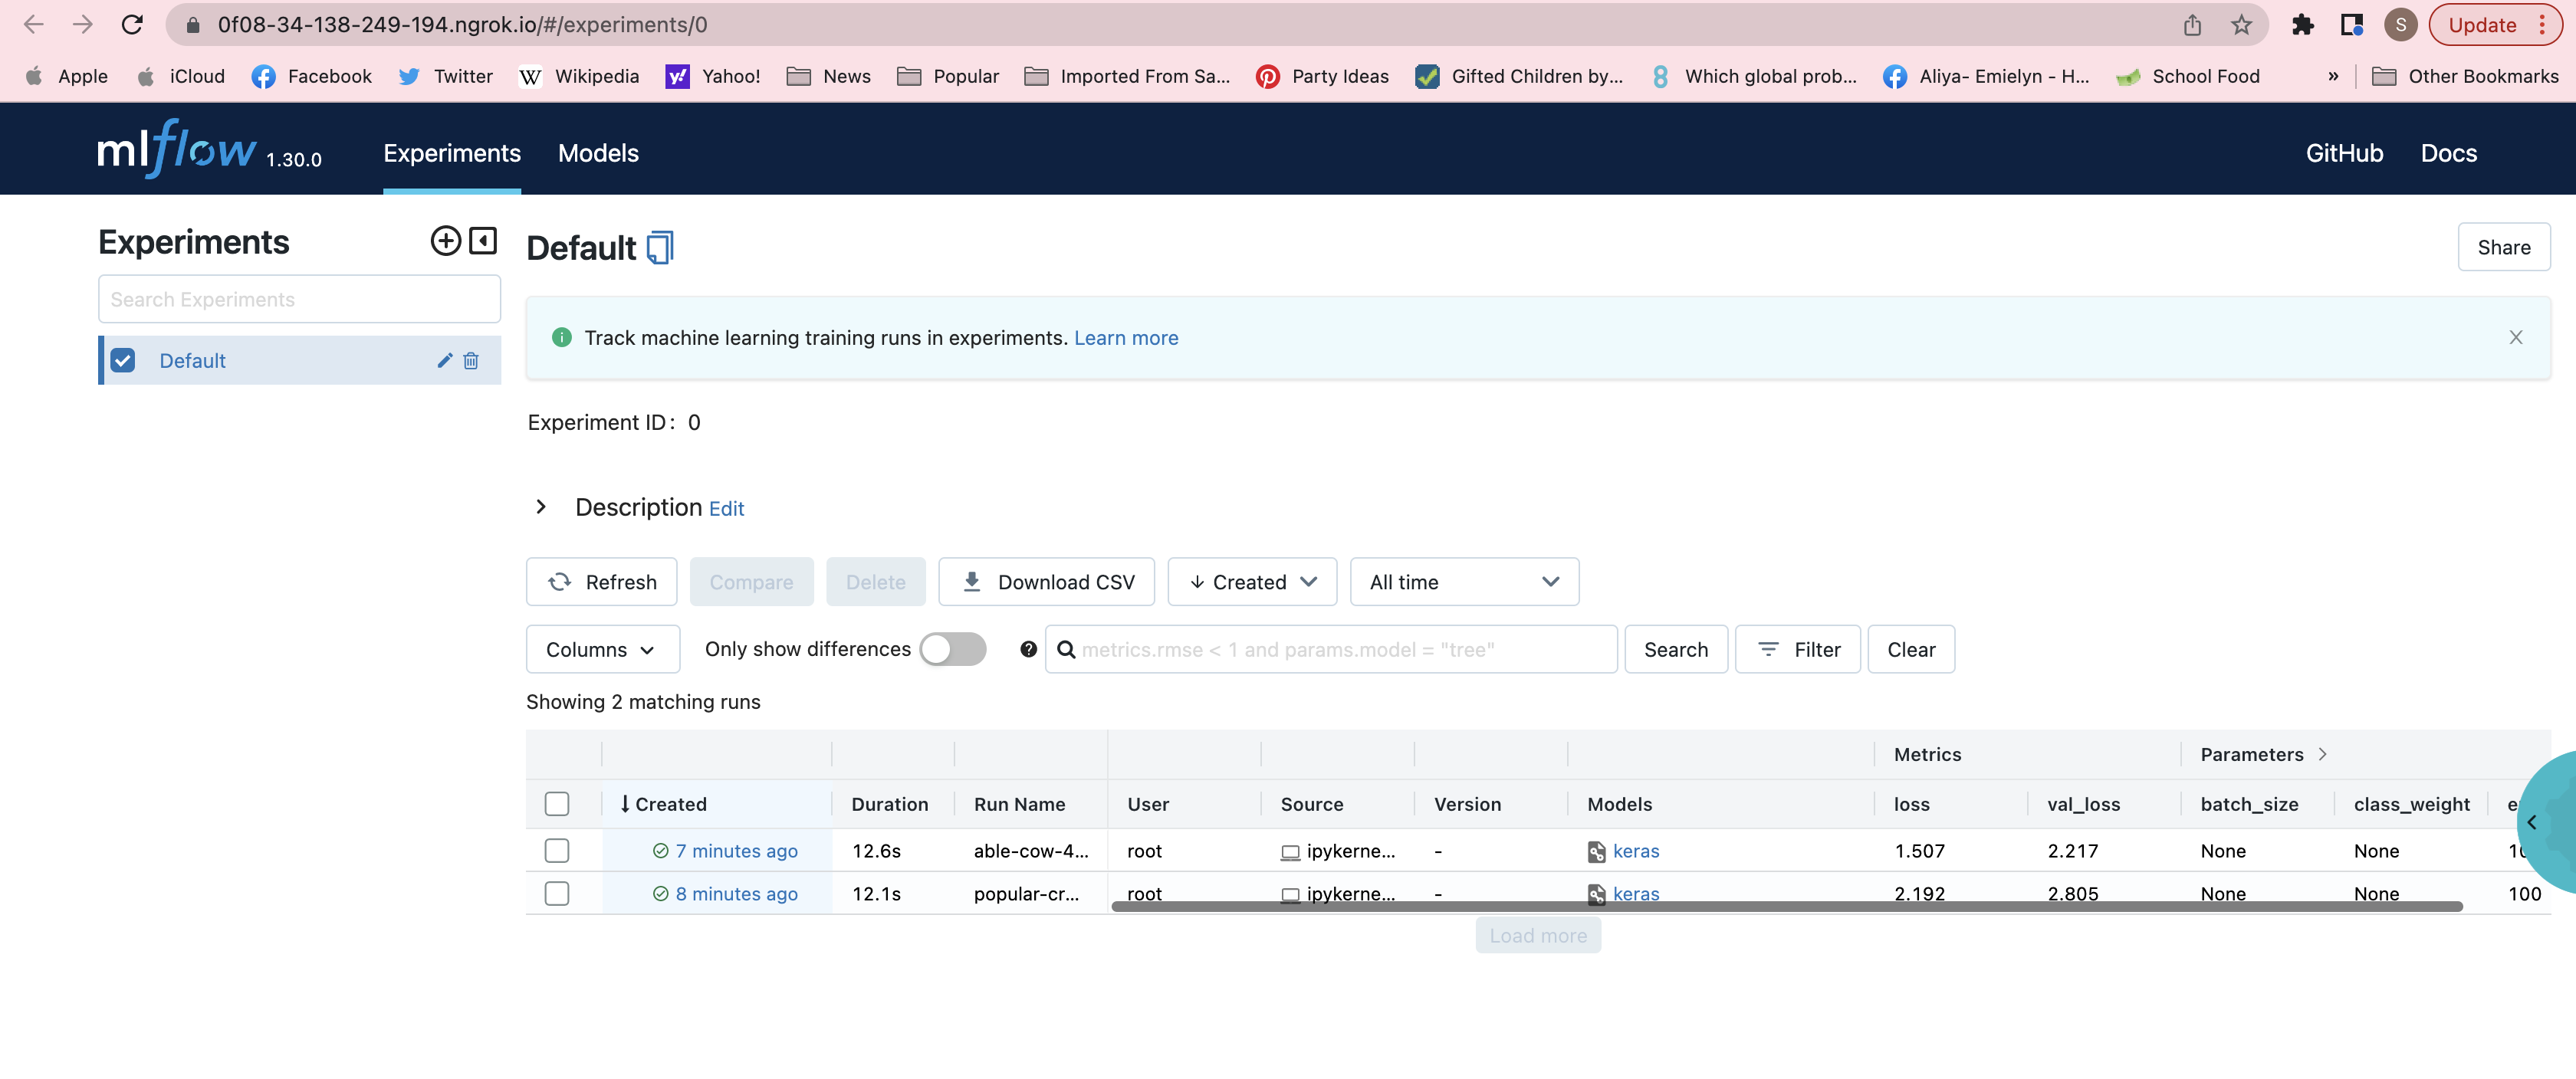

8. Interact with Tracking UI. 

    Open the link, output from the previous cell. get oriented, `Parameters`, `Metrics`, `Artifacts`, and so on.
    
    When you are done, make sure to terminate the open tunnel:

In [64]:
ngrok.kill()

# Task 8 - AutoML with TPOT 🫖

1. Instantiate and train a TPOT auto-ML regressor.

  The parameters are set fairly arbitrarily (if time permits, you shall experiment with different sets of parameters after reading [what each parameter does](http://epistasislab.github.io/tpot/api/#regression)). Use these parameter values:

  `generations`: 10

  `population_size`: 40

  `scoring`: negative mean absolute error; read more in [scoring functions in TPOT](http://epistasislab.github.io/tpot/using/#scoring-functions)

  `verbosity`: 2 (so you can see each generation's performance)

  The final line with create a Python script tpot_products_pipeline.py with the code to create the optimal model found by TPOT.

In [65]:
%%time
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=10, 
                     population_size=40,
                     scoring='neg_mean_absolute_error', # YOUR CODE HERE
                     verbosity=2,
                     random_state=42)
tpot.fit(train_features, train_labels)
print(f"Tpop score on test data: {tpot.score(test_features, test_labels):.2f}")
tpot.export('tpot_mpg_pipeline.py')

Optimization Progress:   0%|          | 0/440 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2.0966391540189604

Generation 2 - Current best internal CV score: -2.0966391540189604

Generation 3 - Current best internal CV score: -2.0748738605538746

Generation 4 - Current best internal CV score: -2.0401819237374825

Generation 5 - Current best internal CV score: -2.0401819237374825

Generation 6 - Current best internal CV score: -2.0401819237374825

Generation 7 - Current best internal CV score: -1.9974466428647244

Generation 8 - Current best internal CV score: -1.9974466428647244

Generation 9 - Current best internal CV score: -1.9974466428647244

Generation 10 - Current best internal CV score: -1.9974466428647244

Best pipeline: ExtraTreesRegressor(RidgeCV(input_matrix), bootstrap=False, max_features=0.6500000000000001, min_samples_leaf=2, min_samples_split=6, n_estimators=100)
Tpop score on test data: -1.68
CPU times: user 8min 11s, sys: 29.2 s, total: 8min 40s
Wall time: 8min 37s


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RidgeCV was fitted with feature names
  "X does not have valid feature names, but"


2. Examine the model pipeline that TPOT regressor offers. If you see any model, function, or class that are not familiar, look them up! 

  Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate. 

In [66]:
cat tpot_mpg_pipeline.py

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: -1.9974466428647244
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=RidgeCV()),
    ExtraTreesRegressor(bootstrap=False, max_features=0.6500000000000001, min_samples_leaf=2, min_samples_split=6, n_estimators=100)
)
# Fix random state for all th

3. Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_mpg_pipeline.py` to build a model on our training set and make predictions on the test set. 
Save the predictions as `y_pred`, and compute appropriate evaluation metric. 
You may find that for this simple data set, the neural network we built outperforms the tree-based model, yet note it is not a conclusion that we can generalize for all tabular data. 

In [67]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer
from copy import copy

In [68]:
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    XGBRegressor(learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.2, verbosity=0)
)

In [69]:
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(train_features, train_labels)
y_pred = exported_pipeline.predict(test_features)

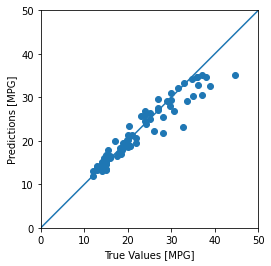

In [70]:
# predictions seem pretty ok for my tree model

test_predictions = y_pred.flatten() 

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


In [71]:
from sklearn.metrics import mean_absolute_error as MAE
mae = MAE(test_labels, y_pred)
print("RMSE : % f" %(mae))

RMSE :  1.681353


In [72]:
test_results['XGBoost'] = mae

In [73]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
linear_model,2.180882
dnn_model,1.721870
reloaded,1.721870
XGBoost,1.681353


# Task 9 - Model Explainability

Last week, we introduced model explainability with SHAP and will continue to incorporate it as part our model output this week.  You can use the [Kernel Explainer](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/neural_networks/Census%20income%20classification%20with%20Keras.html) for explainability of both the Neural Networks and the TPOT classifier.  

In [74]:
import shap

In [75]:
#using the standard way

dnn_explainer = shap.KernelExplainer(dnn_model, test_features) #YOUR CODE GOES HERE

In [76]:
dnn_shap_values = dnn_explainer.shap_values(test_features, nsamples=500)

  0%|          | 0/78 [00:00<?, ?it/s]

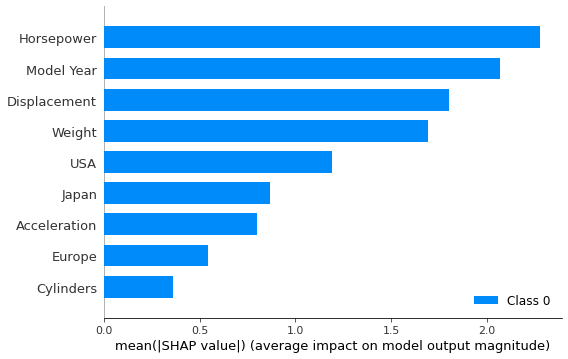

In [78]:
#all hail horsepower
shap.summary_plot(dnn_shap_values, test_features, plot_type='bar')

In [79]:
shap.initjs()

shap.force_plot(
    dnn_explainer.expected_value,
    dnn_shap_values[0],
    test_features,
)

In [80]:
#don't really have all 3 arrays somehow - values, base and data
dnn_shap_values

[array([[-0.153, -2.137, -3.539, -1.469,  1.586, -2.093, -0.114, -0.361,
          1.023],
        [-0.313, -2.36 , -4.622, -2.062,  3.862, -2.293, -0.059, -0.184,
          0.966],
        [-0.307, -2.285, -4.721, -2.008,  2.499, -2.377, -0.077, -0.184,
          0.863],
        [-0.274, -2.382, -4.286, -1.699,  4.147, -2.198, -0.071, -0.25 ,
          1.057],
        [-0.128, -2.441, -2.717, -1.509,  3.096, -1.769, -0.035, -0.324,
          1.099],
        [-0.336, -2.761, -4.343, -0.465,  2.863, -2.427, -0.077, -0.191,
          0.954],
        [-0.642, -0.448,  2.097,  0.291, -0.816, -2.121, -0.313, -0.657,
          1.036],
        [ 1.045,  2.441,  1.222,  1.435, -0.15 , -2.466,  2.359, -1.046,
         -2.443],
        [ 0.452,  2.403,  1.834,  2.517, -0.267, -2.312, -0.756,  2.865,
         -2.429],
        [-0.163, -2.214, -4.005, -1.865,  1.352, -2.278, -0.111, -0.322,
          0.888],
        [-0.045, -1.908, -2.869, -1.75 ,  0.458, -2.202, -0.152, -0.401,
          0.981],

In [ ]:
#doing it the way in the instructions doesn't work; everything bombs

def f(X):
    return dnn_model.predict([X[:,i] for i in range(X.shape[1])]).flatten()

In [81]:
#as per Chris

def f(X):
  return dnn_model.predict(X).flatten()

In [82]:
dnn_explainer = shap.KernelExplainer(f, train_features.iloc[:50, :])

2/2 [==============================] - 0s 6ms/step


In [83]:
shap_values = dnn_explainer.shap_values(train_features.iloc[:50, :], nsamples = 500)

  0%|          | 0/50 [00:00<?, ?it/s]

782/782 [==============================] - 1s 1ms/step


In [84]:
shap_values

array([[-0.111,  0.301,  0.553, -0.836, -0.785,  2.851, -0.424, -0.592,
         0.351],
       [ 0.133, -2.322, -2.166, -1.87 ,  0.168,  1.47 , -0.066, -0.326,
         0.824],
       [-0.087, -2.322, -3.688, -1.748,  1.723, -2.168, -0.164, -0.377,
         1.036],
       [-0.811, -0.99 ,  0.955, -0.826, -0.957,  1.461, -0.346, -0.623,
         0.54 ],
       [-0.662, -1.328,  0.905, -1.644, -0.609,  3.488, -0.216, -0.468,
         0.562],
       [-0.773, -0.928,  0.155, -1.058, -0.923,  0.548, -0.354, -0.595,
         0.613],
       [ 0.18 ,  2.078,  2.192,  1.893, -0.26 , -0.196, -0.763,  3.491,
        -1.816],
       [ 0.242,  2.218,  2.559,  2.615,  0.146,  1.572, -0.333, -0.481,
         0.887],
       [-0.225, -2.51 , -5.117, -2.042,  1.45 , -2.179, -0.117, -0.235,
         0.74 ],
       [-0.094, -2.636, -4.24 , -2.026,  1.274, -1.386, -0.085, -0.274,
         0.835],
       [-0.01 ,  1.616,  0.658,  0.42 , -0.908,  5.492, -0.406, -0.554,
         0.351],
       [ 0.632,  2.33

In [85]:
shap.initjs()
shap.force_plot(
    dnn_explainer.expected_value,
    shap_values,
    train_features.iloc[:50, :],
)

In [86]:
#not providing base values etc. still

def custom_masker(mask, X):
  return (X*mask).reshape(1, len(X))
  

explainer = shap.Explainer(f, custom_masker)

shap_values = explainer(train_features[:10])

1/1 [==============================] - 0s 18ms/step


Permutation explainer:  30%|███       | 3/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


Permutation explainer:  50%|█████     | 5/10 [00:14<00:08,  1.64s/it]

1/1 [==============================] - 0s 26ms/step


Permutation explainer:  60%|██████    | 6/10 [00:18<00:10,  2.65s/it]

1/1 [==============================] - 0s 21ms/step


Permutation explainer:  70%|███████   | 7/10 [00:22<00:09,  3.20s/it]

1/1 [==============================] - 0s 18ms/step


Permutation explainer:  80%|████████  | 8/10 [00:25<00:06,  3.23s/it]

1/1 [==============================] - 0s 19ms/step


Permutation explainer:  90%|█████████ | 9/10 [00:28<00:03,  3.23s/it]

1/1 [==============================] - 0s 18ms/step


Permutation explainer: 100%|██████████| 10/10 [00:31<00:00,  3.24s/it]

1/1 [==============================] - 0s 17ms/step


Permutation explainer: 11it [00:35,  4.41s/it]


In [87]:
shap_values[0]

.values =
array([ -3.401,  -3.932,  -7.834,  -9.999, -13.898, -43.83 ,   0.   ,
         0.   ,   5.851])

.base_values =
101.26820373535156

.data =
array([   4. ,  151. ,   90. , 3003. ,   20.1,   80. ,    0. ,    0. ,
          1. ])

In [88]:
shap_values.base_values

array([101.268, 101.268, 101.268, 101.268, 101.268, 101.268, 101.268,
       101.268, 101.268, 101.268])

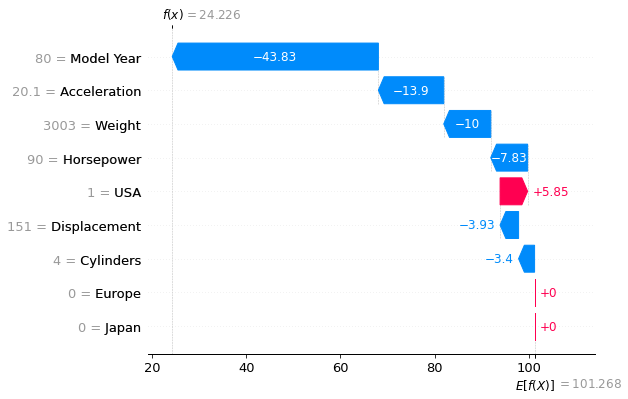

In [89]:
shap.plots.waterfall(shap_values[0])

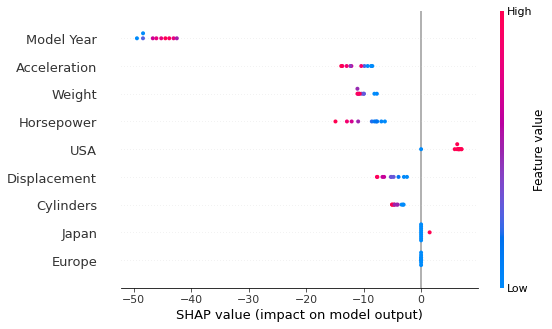

In [90]:
shap.plots.beeswarm(shap_values) 

In [91]:
# 2nd part of task with different model - clearly doesn't work simply for 
# an exported pipeline


tpot_explainer = shap.KernelExplainer(exported_pipeline, test_features)

Provided model function fails when applied to the provided data set.


TypeError: ignored

In [92]:
def f(X):
  return exported_pipeline.predict(X).flatten()

In [93]:
tpot_explainer = shap.KernelExplainer(f, test_features)

In [94]:
tpot_shap_values = tpot_explainer.shap_values(test_features, nsamples = 500)

  0%|          | 0/78 [00:00<?, ?it/s]

In [96]:
shap.initjs()
shap.force_plot(
    tpot_explainer.expected_value,
    tpot_shap_values,
    test_features,
)

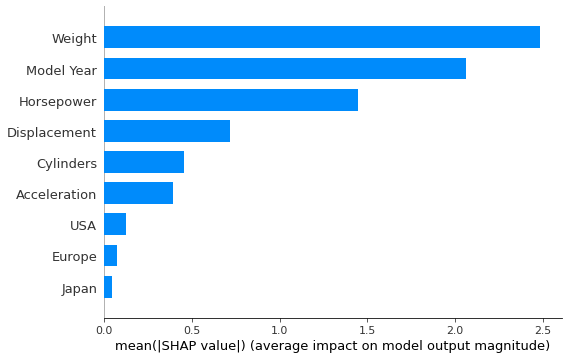

In [97]:
# the decision tree emphasized weight and not horsepower
shap.summary_plot(tpot_shap_values, train_features.iloc[:50, :], plot_type='bar')

# Task 10 - Taking it to the Next Level! 📶

Let's take our models and make a model comparison demo like we did last week, but this time you're taking the lead!  
    
1. Save your training dataset as a CSV file so that it can be used in the Streamlit app.
1. Build a results DataFrame and save it as a CSV so that it can be used in the Streamlit app.
1. In Tab 1 - Raw Data:
* Display your training dataset in a Streamlit DataFrame (`st.DataFrame`).
* Build 1-2 interactive Plotly visualizations that explore the dataset (correlations, scatterplot, etc.)
2. In Tab 2 - Model Results:
* Display your performance metrics appropriately using 2-3 metrics for model comparison.
3. In Tab 3 - Model Explainability:
* Make local and global explainability plots to compare two models at a time side-by-side.  [Here](https://www.kaggle.com/code/elsa155026/uciheart-kernel-shap-and-interactive-visualization/notebook) is a good example if how to create some different explainability plots using Plotly.

In [98]:
# 1 save training dataset to csv
train_dataset.to_csv("fueltrain_dataset.csv")

In [99]:
# 2
from collections import defaultdict
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error as MAE
mae = MAE(test_labels, y_pred)

results_data = defaultdict(list)

models = ["Linear Regression", "Deep Neural Network", "XGBoost"]

for model, pred in zip(models, [linear_model.predict(test_features), dnn_model.predict(test_features), exported_pipeline.predict(test_features)]):
    mae=MAE(test_labels, pred)
    rmse=mean_squared_error(test_labels, pred)
    
    results_data['model'].append(model)
    results_data['mean absolute error'].append(mae)
    results_data['mean squared error'].append(rmse)
    
results_df = pd.DataFrame(results_data)
results_df

3/3 [==============================] - 0s 4ms/step


,model,mean absolute error,mean squared error
0,Linear Regression,2.180882,10.053407
1,Deep Neural Network,1.721870,7.429687
2,XGBoost,1.681353,6.573442


In [100]:
# 2 Write our results_df to CSV
results_df.to_csv("model_results.csv")

In [101]:
!pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.3 MB 8.0 MB/s 
     |████████████████████████████████| 164 kB 52.2 MB/s 
     |████████████████████████████████| 4.7 MB 45.6 MB/s 
     |████████████████████████████████| 78 kB 7.2 MB/s 
     |████████████████████████████████| 237 kB 50.7 MB/s 
     |████████████████████████████████| 51 kB 7.6 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=ee0728d26174b840f05d37a4d320d19bad61c820b5c3a5b9ec9f94658bcb69b1
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators


In [102]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
%%writefile fuelapp.py

import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import streamlit as st
import streamlit.components.v1 as components
from PIL import Image

# Add and resize an image to the top of the app
img_fuel = Image.open("fuel_efficiency.png")
st.image(img_fuel, width=700)

st.markdown("<h1 style='text-align: center; color: black;'>Fuel Efficiency</h1>", unsafe_allow_html=True)

# Import train dataset to DataFrame
train_df = pd.read_csv("fueltrain_dataset.csv")
model_results_df = pd.read_csv("model_results.csv")

# Create sidebar for user selection
with st.sidebar:
    # Add FB logo
    st.image("https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" )    

    # Available models for selection

    # YOUR CODE GOES HERE!
    models = ["Linear Regression", "DNN", "XGBoost"]

    # Add model select boxes
    model1_select = st.selectbox(
        "Choose Model 1:",
        (models)
    )
    
    # Remove selected model 1 from model list
    # App refreshes with every selection change.
    models.remove(model1_select)
    
    model2_select = st.selectbox(
        "Choose Model 2:",
        (models)
    )

   # Remove selected model 2 from model list
    # App refreshes with every selection change.

    models.remove(model2_select)
    
    model3_select = st.selectbox(
        "Choose Model 3:",
        (models)
    )

# Create tabs for separation of tasks
tab1, tab2, tab3 = st.tabs(["🗃 Data", "🔎 Model Results", "🤓 Model Explainability"])

with tab1:    
    # Data Section Header
    st.header("Raw Data")

    # Display first 100 samples of the dateframe
    st.dataframe(train_dataset.head(100))

    st.header("Correlations")

    # Heatmap
    corr = train_dataset.corr()
    fig = px.imshow(corr)
    st.write(fig)

with tab2:    
    
    # YOUR CODE GOES HERE!

    # Data Section Header
    st.header("Model Results")

    # Display results dateframe
    st.dataframe(model_results_df)


with tab3: 

    # YOUR CODE GOES HERE!
    # Use columns to separate visualizations for models

    col1, col2 = st.columns(2)

     # Include plots for local and global explanability!
     with col1:
      
      st.header(model2_select)





    
    st.header(model3_select)

Writing fuelapp.py


In [105]:
!ls

dnn_model  fuelapp.py		  mlruns	     sample_data
drive	   fueltrain_dataset.csv  model_results.csv  tpot_mpg_pipeline.py


In [131]:
!streamlit run fuelapp.py --server.port 5001




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:5001
  External URL: http://35.233.241.193:5001

  Stopping...
  Stopping...


In [132]:
!streamlit run app.py &>/dev/null&

In [133]:
# run tracking UI in the background
# get_ipython().system_raw("mlflow ui --port 5000 &") 

# create remote tunnel using ngrok.com to allow local port access
from pyngrok import ngrok
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (see Note above)
NGROK_AUTH_TOKEN = "2EpLAwBPBxY5nlcuUvddGKOumUD_7pfLCJRhe9ku896xysV46"  # YOUR CODE HERE
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 8501 for http://localhost:8501
ngrok_tunnel = ngrok.connect(addr="8501", proto="http", bind_tls=True)

ngrok_tunnel

<NgrokTunnel: "https://32f4-35-233-241-193.ngrok.io" -> "http://localhost:8501">

In [135]:
ngrok.kill()

What is Normalization and how does Normalization make training a model more stable?

When features are in different scales, then their relative importance in the model is affected by the scale. For example, if a feature is in millions of dollars, while another is in single digits, i.e. number of children, the former feature can steer model performance in a certain direction because of the bigger numbers. Any model that uses distance measures, e.g. clustering, would be affected by such differences in dimensions and distributions.

The purpose of normalization is to transform the data such that each feature is dimensionless and has similar distributions. No single variable then steers the model. And, it dramatically improves model accuracy.

There are several methods of normalization such as min-max (distance of each point from min over overall distance), mean, and z-score normalization.

What are loss and optimizer functions and how do they work?

Loss function is the difference between the predicted value from a neural network and the actual value of the target variable. It is the error created by the neural network when mapping inputs to outputs. 

An optimizer function is an algorithm that finds the parameters (weights) of a neural network by minimizing the loss function.

There are different optimzer functions including gradient descent, stochastic gradient descent with and without momentum, mini-batch gradient descent, adagrad, RMSProp, AdaDelta, Adam etc.

What is Gradient Descent and how does it work?

Gradient Descent is the most popular optimzer function in neural networks. Gradient descent starts with somes weights, sees the loss function, and searches for a loss function lower than current. It updates the value of the coefficients and repeats the process till a local minimum is reached, i.e. a point from which any direction increases the cost.

What is an activation function?
What are the outputs of the following activation functions: ReLU, Softmax, Tanh, Sigmoid

The activation function is the non-linear function that we apply over the output data coming out of a particular layer of neurons before it propagates as the input to the next layer. If there is no activation function the layer is only performing a linear transformation of the inputs using weights and biases, i.e. essentially a linear regression.

It can be shown, mathematically, that the universal approximation power of a deep neural network - the ability to approximate any mathematical function to a sufficient degree - does not hold without these nonlinear activation stages in between the layers. Without it, the network will not be able to learn complex patterns from the data.

There are many types of activation functions as seen in the list below. Which one we choose, depends on the nature of the data.

Outputs:
ReLU - 0 when input is negative and the input directly when it is positive

Softmax - vector with probabilities of each possible outcome. probabilities sum to 1 for all possible outcomes or classes in the vector. Can handle multiple classes.

Tanh - converts a real valued input into the [-1, 1] range centering it on zero unlike the Sigmoid activation function. 

Sigmoid - gives a single probabilty between 0 and 1 of the real value input

What is the TPOT algorithm and how does it work?
What does TPOT stand for?

Tree-Based Pipeline Optimization Tool

The goal is to automate the machine learning pipeline. The open source software package recursively combines and elimnates features to output the best random forest classifier. Instead of having to search individually through various models, the software does it for you.

# Additional Resources

- [Tensorflow playground](https://playground.tensorflow.org/) for an interactive experience to understand how nueral networkds work.

- [An Introduction to Deep Learning for Tabular Data](https://www.fast.ai/2018/04/29/categorical-embeddings/) covers embeddings for categorical variables. 

- [Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/) demonstrates using `class_weight` to handle imbalanced classification problems. 

# Acknowledgement and Copyright

##### Acknowledgement

This notebook is adapted from [tensorflow/keras tuorial - regression](https://www.tensorflow.org/tutorials/keras/regression)

##### Copyright 2018 The TensorFlow Authors.

@title Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

@title MIT License

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a
copy of this software and associated documentation files (the "Software"),
to deal in the Software without restriction, including without limitation
the rights to use, copy, modify, merge, publish, distribute, sublicense,
and/or sell copies of the Software, and to permit persons to whom the
Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
DEALINGS IN THE SOFTWARE.